# Gaussian on a Grid Test with compositional score matching

In this notebook, we will test the compositional score matching on a hierarchical problem defined on a grid.
- The observations are on grid with `n_grid` x `n_grid` points.
- The global parameters are the same for all grid points with hyper-priors:
$$ \mu \sim \mathcal{N}(0, 3^2),\qquad \log\sigma \sim \mathcal{N}(0, 1^2)$$

- The local parameters are different for each grid point
$$ \theta_{i,j} \sim \mathcal{N}(\mu, \sigma^2)$$

-  In each grid point, we have a Brownian motion with drift:
$$ dx_t = \theta \cdot dt + \sqrt{dt} \cdot dW_t$$
- We observe $T=10$ time points for each grid point over a time horizon of `max_time=1`.

In [1]:
import os

import numpy as np
from IPython.display import clear_output

os.environ['KERAS_BACKEND'] = 'torch'
from bayesflow import diagnostics

from problems.gaussian_grid import Prior, Simulator, visualize_simulation_output, plot_shrinkage, get_stan_posterior

/Users/jonas.arruda/miniconda/envs/hierarchical-score-matching/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
11:39:21 - cmdstanpy - INFO - compiling stan file /var/folders/6l/dj45z5dn7zn0djmp1vjb65bh0000gn/T/tmps00zo0rh/tmpfgt488qx.stan to exe file /Users/jonas.arruda/PyCharm Projects/hierarchical-abi/problems/gaussian_grid
INFO:cmdstanpy:compiling stan file /var/folders/6l/dj45z5dn7zn0djmp1vjb65bh0000gn/T/tmps00zo0rh/tmpfgt488qx.stan to exe file /Users/jonas.arruda/PyCharm Projects/hierarchical-abi/problems/gaussian_grid
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=gaussian_grid.stan /var/folders/6l/dj45z5dn7zn0djmp1vjb65bh0000gn/T/tmps00zo0rh/tmpfgt488qx
cwd: /Users/jonas.arruda/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc -

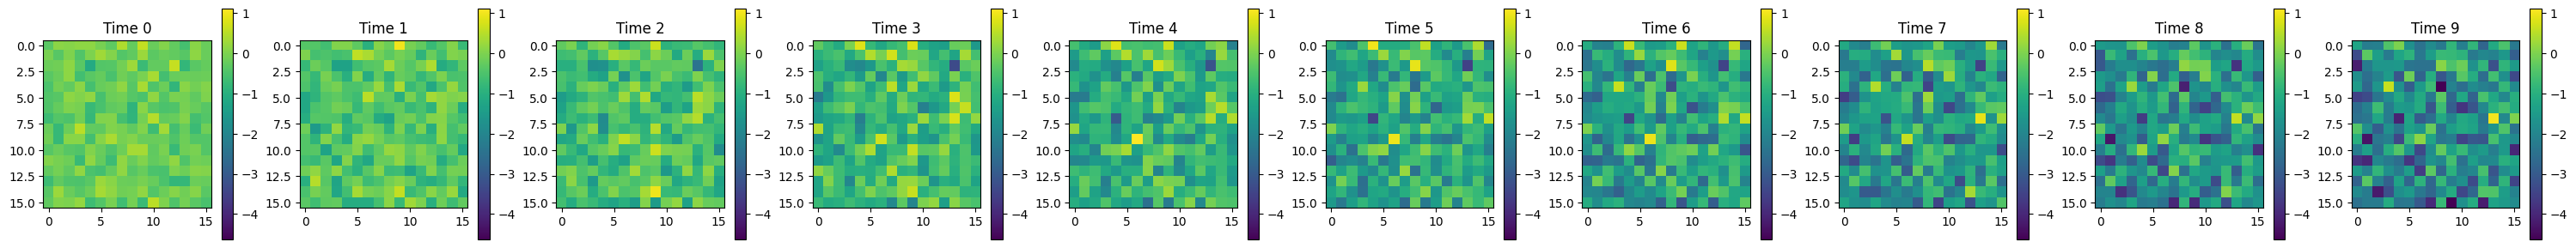

In [7]:
n_grid = 16
T = 10
N = n_grid * n_grid  # number of samples
data_samples = 100

prior = Prior(n_time_points=T)
simulator = Simulator(n_time_points=T)

global_param_names = [r'$\mu$', r'$\log \sigma$']
local_param_names = [r'$\theta_{' + str(i) + '}$' for i in range(n_grid * n_grid)]

# test the simulator
sim_test = simulator(prior.sample_full(1, n_grid=n_grid))['observable']
if T <= 10:
    visualize_simulation_output(sim_test)

In [ ]:
np.random.seed(42)

global_posteriors = []
local_posteriors = []

true_global = []
true_local = []

for i in range(data_samples):
    clear_output() #wait=True)
    print(i)
    param_sample = prior.sample_full(1, n_grid=n_grid)
    true_global.append([param_sample['mu'][0, 0], param_sample['log_sigma'][0, 0]])
    true_local.append(param_sample['theta'].flatten())
    sim_test = simulator(param_sample)['increments'][0]

    global_posterior, local_posterior = get_stan_posterior(sim_test, dt_obs=simulator.dt)
    global_posteriors.append(global_posterior)
    local_posteriors.append(local_posterior)

# make numpy arrays
global_posterior = np.stack(global_posteriors, axis=0)
local_posterior = np.stack(local_posteriors, axis=0).transpose(0, 2, 1)

true_global = np.stack(true_global, axis=0)
true_local = np.stack(true_local, axis=0)

DEBUG:cmdstanpy:cmd: /Users/jonas.arruda/PyCharm Projects/hierarchical-abi/problems/gaussian_grid info
cwd: None
DEBUG:cmdstanpy:input tempfile: /var/folders/6l/dj45z5dn7zn0djmp1vjb65bh0000gn/T/tmpxwx3qo8o/_fbx9ldt.json
11:49:58 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:CmdStan args: ['/Users/jonas.arruda/PyCharm Projects/hierarchical-abi/problems/gaussian_grid', 'id=1', 'random', 'seed=13583', 'data', 'file=/var/folders/6l/dj45z5dn7zn0djmp1vjb65bh0000gn/T/tmpxwx3qo8o/_fbx9ldt.json', 'output', 'file=/var/folders/6l/dj45z5dn7zn0djmp1vjb65bh0000gn/T/tmpxwx3qo8o/gaussian_grid_msv3r3c/gaussian_grid-20250318114958_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
11:49:58 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:ru

13


# Plotting

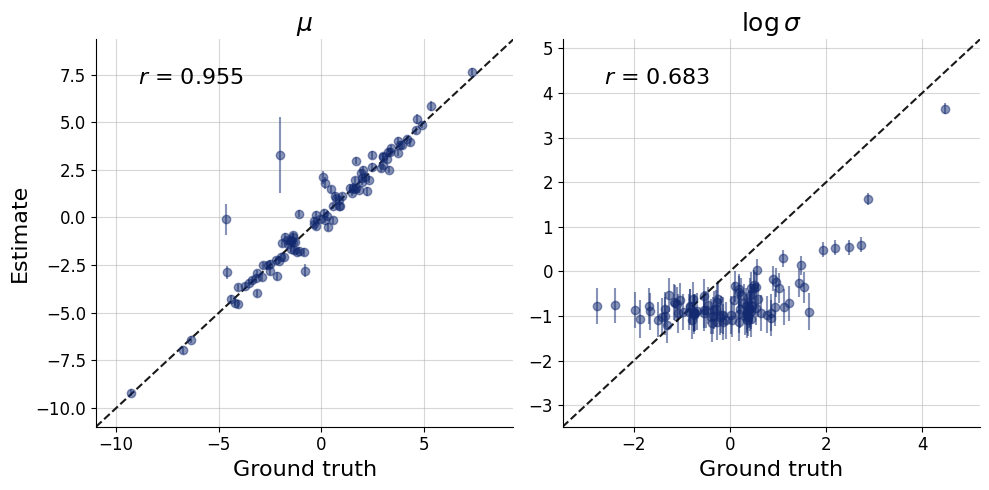

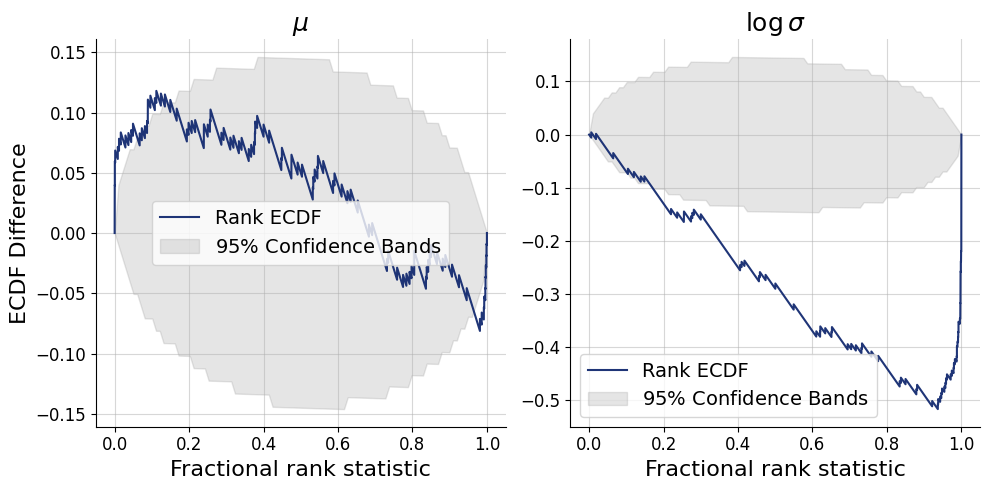

In [4]:
diagnostics.recovery(global_posterior, true_global, variable_names=global_param_names)
diagnostics.calibration_ecdf(global_posterior, true_global, difference=True, variable_names=global_param_names);

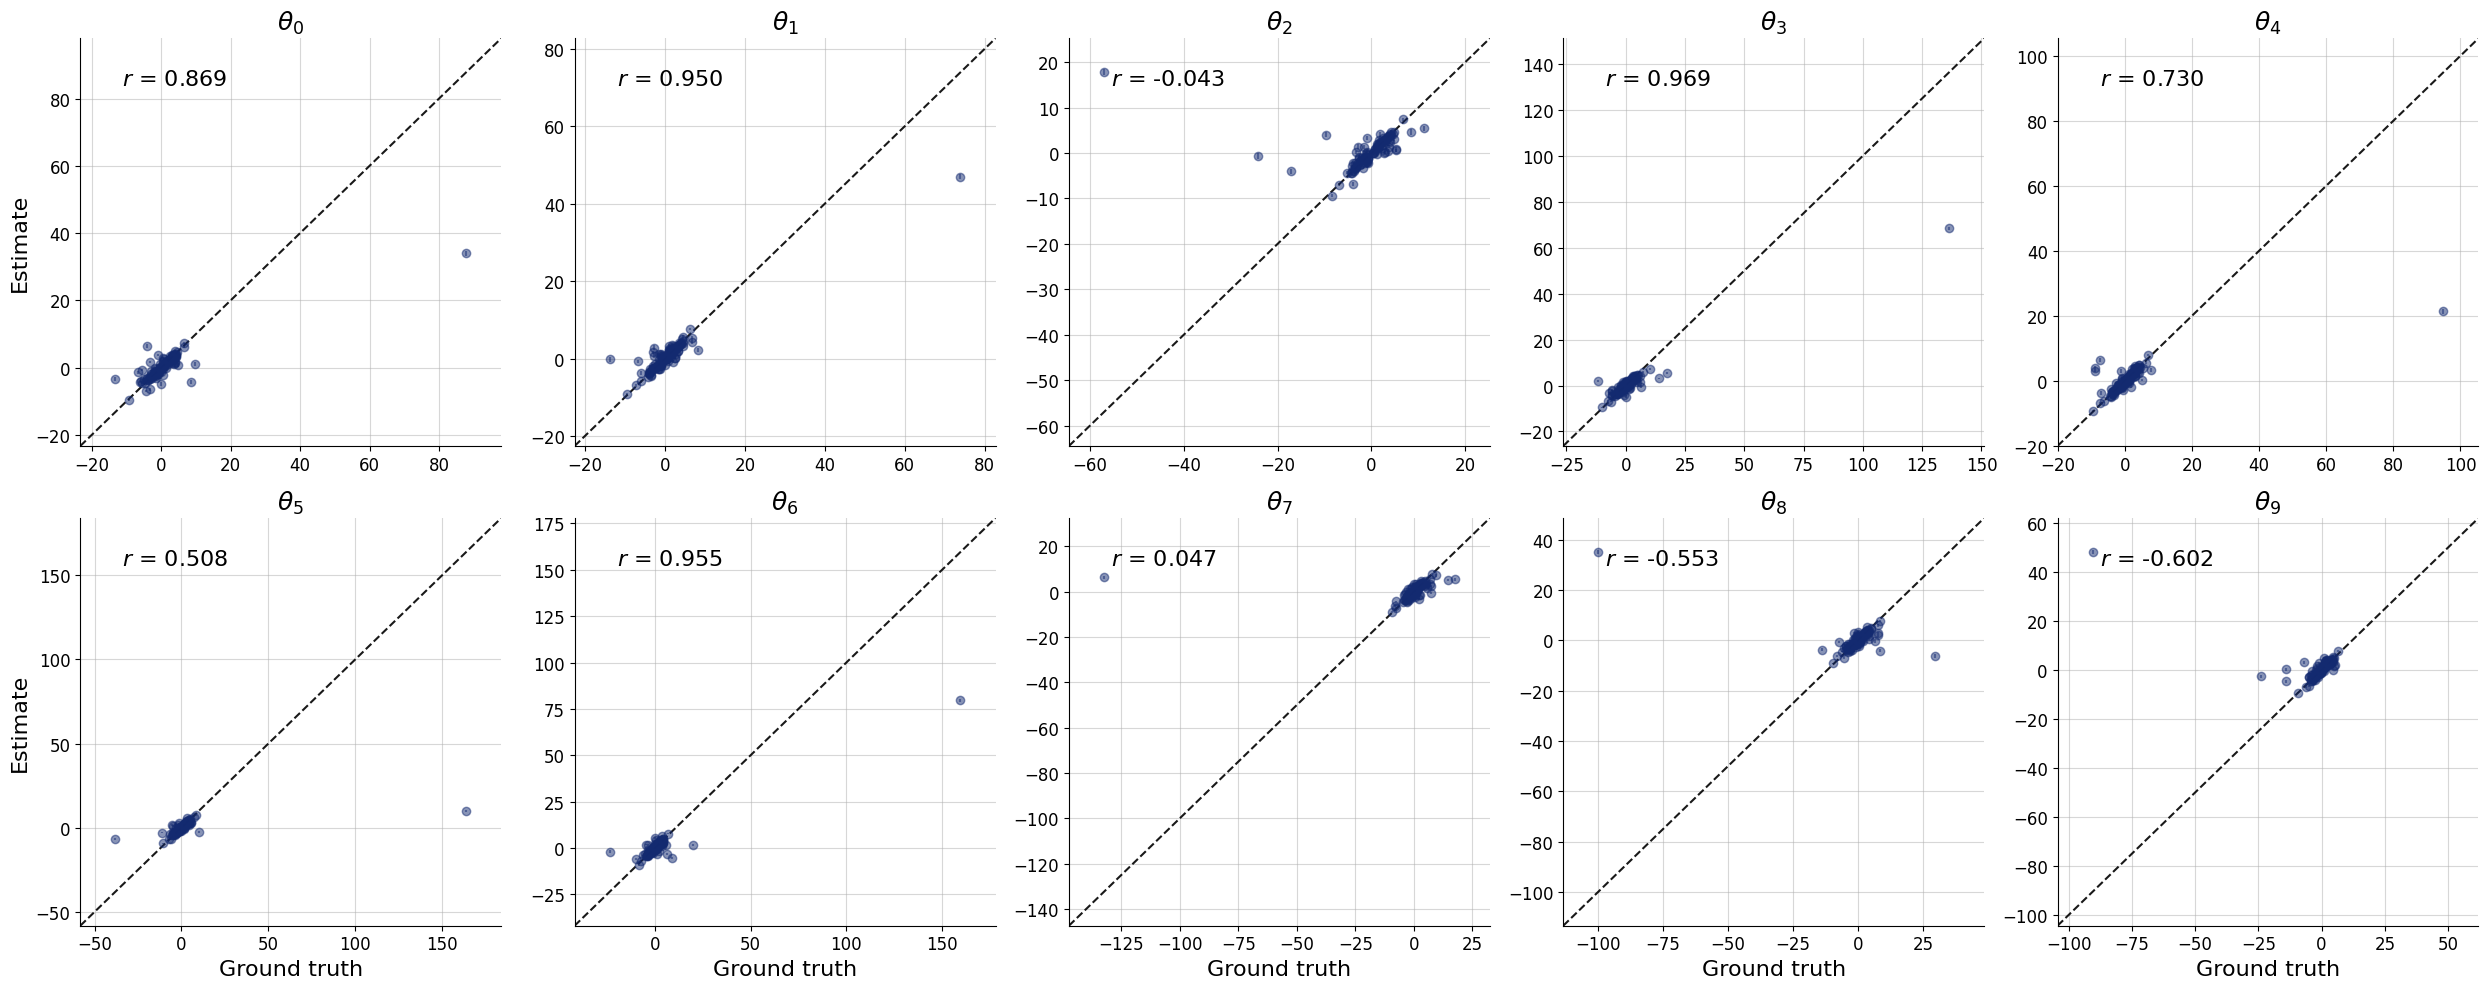

In [5]:
diagnostics.recovery(local_posterior[:, :, :10], true_local[:, :10], variable_names=local_param_names[:10]);

In [ ]:
plot_shrinkage(global_posterior, local_posterior[:, :, :, np.newaxis])